# DART Overview
This notebook provides an interactive interface to the DART dataset.

In [1]:
%matplotlib inline

import json
from pathlib import Path
from collections import Counter
from functools import partial
import logging
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from nltk.tokenize import word_tokenize, sent_tokenize

from dart_nbutils.tree import print_tree, generate_tree

In [2]:
DART_VERSION = "v1.1.1"
SPLITS = ['train', 'dev', 'test']
data_dir = Path(f"../data/{DART_VERSION}")
prefix = f"dart-{DART_VERSION}"

In [3]:
n_unique = lambda x: len(set(x))
n_unique_str = lambda x: n_unique([y.upper() for y in x])
describe_fns = [np.min, np.median, np.mean, np.max]
describe = lambda x: np.round(tuple(f(x) for f in describe_fns), 2)

In [4]:
def load_dart(split):
    assert split in SPLITS
    with open(data_dir / f"{prefix}-full-{split}.json") as f:
        return json.load(f)

### Visualizing RDF trees in DART

In [5]:
# Bring the devel set into memory
devel = load_dart('dev')

In [6]:
# Inspect the first record
devel[0]

{'tripleset': [['Mars Hill College', 'JOINED', '1973'],
  ['Mars Hill College', 'LOCATION', 'Mars Hill, North Carolina']],
 'subtree_was_extended': True,
 'annotations': [{'source': 'WikiSQL_decl_sents',
   'text': 'A school from Mars Hill, North Carolina, joined in 1973.'}]}

In [7]:
# Visualize the RDF tree from the first record
tree = generate_tree(devel[0])
print_tree(tree)

Mars Hill College
├── JOINED:1973
└── LOCATION:Mars Hill, North Carolina


In [8]:
# Visualize another interesting RDF tree
tree = generate_tree(devel[565])
print_tree(tree)

Abilene Regional Airport
└── CITY_SERVED:Abilene, Texas
    ├── IS_PART_OF:Taylor County, Texas
    └── COUNTRY:United States


### Collate statistics on DART

In [9]:
# Function to traverse a DART file (loaded with load_dart) and
# generate summary outputs.
def compute_stats(data):
    # Gather statistics as we traverse the dataset
    stats = {
        'triples': set(),

        'subjects': [],
        'predicates': [],
        'objects': [],

        'vocabulary': set(),
        'srs': [],

        'triples_per_tripleset': [],

        'words_per_sr': [],
        'sents_per_sr': [],

        'sources': []
    }
    
    # Traverse the dataset
    for entry in data:
        stats['triples_per_tripleset'].append(len(entry['tripleset']))

        # Iterate through triples in tripleset
        for triple in entry['tripleset']:
            S, P, O = triple
            stats['triples'].add(tuple(t.upper() for t in triple))

            stats['subjects'].append(S)
            stats['predicates'].append(P)
            stats['objects'].append(O)

        # Iterate through annotations
        for annotation in entry['annotations']:
            sr = annotation['text']
            stats['srs'].append(sr)

            words = word_tokenize(sr)
            sents = sent_tokenize(sr)

            stats['words_per_sr'].append(len(words))
            stats['sents_per_sr'].append(len(sents))

            for word in words:
                stats['vocabulary'].add(word)
    
    # Return entities and summary statistics
    entities = {
        'subjects': stats['subjects'], 
        'predicates': stats['predicates'], 
        'objects': stats['objects'],
        
        'triples_per_tripleset': stats['triples_per_tripleset'],
        
        'words_per_sr': stats['words_per_sr'],
        'sents_per_sr': stats['sents_per_sr'],

        'sources': stats['sources']
    }
    results = {
        '# triplesets': len(data),

        '# unique subjects': n_unique_str(stats['subjects']),
        '# unique predicates': n_unique_str(stats['predicates']),
        '# unique objects': n_unique_str(stats['objects']),

        "# triples / tripleset": describe(stats['triples_per_tripleset']),
        "# words / sr": describe(stats['words_per_sr']),
        "# sents / sr": describe(stats['sents_per_sr']),

        "# unique triples": len(stats['triples']),
        "# unique words": len(stats['vocabulary']),
        "# unique srs": n_unique(stats['srs']),
        "# total srs": len(stats['srs']),
    }
    
    return entities, results

In [10]:
splits_data = {x: load_dart(x) for x in SPLITS}
processed = {k: compute_stats(v) for k, v in splits_data.items()}
dart_statistics = pd.DataFrame({k: v[1] for k, v in processed.items()})

In [11]:
dart_statistics

,train,dev,test
# triplesets,30526,2768,6959
# unique subjects,9680,730,1120
# unique predicates,4220,419,494
# unique objects,18846,1679,2736
# triples / tripleset,"[1.0, 3.0, 3.38, 10.0]","[1.0, 4.0, 3.78, 8.0]","[1.0, 3.0, 3.43, 7.0]"
# words / sr,"[1.0, 20.0, 20.96, 107.0]","[4.0, 23.0, 23.51, 81.0]","[0.0, 23.0, 23.43, 81.0]"
# sents / sr,"[1.0, 1.0, 1.43, 9.0]","[1.0, 1.0, 1.58, 5.0]","[0.0, 1.0, 1.53, 6.0]"
# unique triples,29072,2289,3613
# unique words,30192,5094,7187
# unique srs,61520,6812,9952


### Distributions

In [12]:
def make_field_distplot(field, processed, fn=sns.distplot):
    cols = ["split", field]
    df = pd.DataFrame([(x, processed[x][0][field]) for x in SPLITS], columns=cols)
    df = df.explode(field)
    g = sns.FacetGrid(df, col="split", margin_titles=True)
    g.map(fn, field)

#### Triples per tripleset

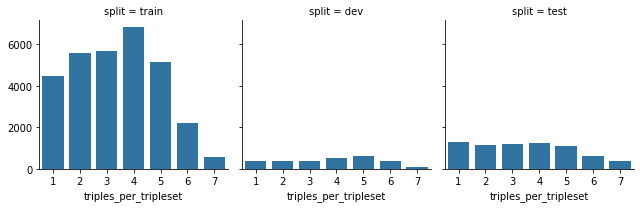

In [13]:
make_field_distplot("triples_per_tripleset", processed, fn=sns.countplot)

#### Words per surface realization

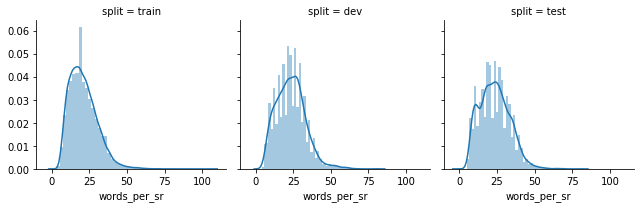

In [14]:
make_field_distplot("words_per_sr", processed)

#### Sentences per surface realization

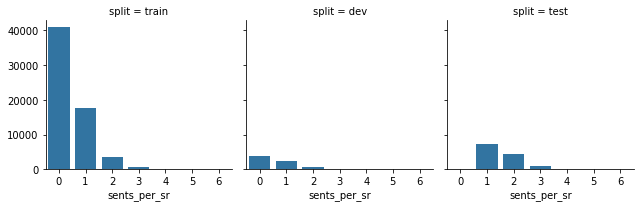

In [15]:
make_field_distplot("sents_per_sr", processed, fn=sns.countplot)

### Triple entry overlap

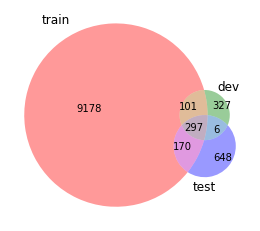

In [16]:
# Subjects
split_subjects = [set(processed[x][0]['subjects']) for x in SPLITS]
venn3(subsets=split_subjects, set_labels=SPLITS)
plt.show()

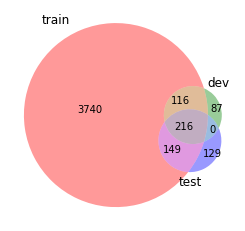

In [17]:
# Predicates
split_predicates = [set(processed[x][0]['predicates']) for x in SPLITS]
venn3(subsets=split_predicates, set_labels=SPLITS)
plt.show()

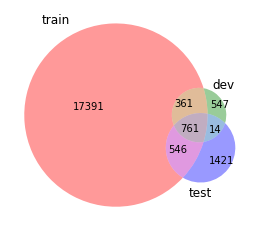

In [18]:
# Objects
split_objects = [set(processed[x][0]['objects']) for x in SPLITS]
venn3(subsets=split_objects, set_labels=SPLITS)
plt.show()